<IPython.core.display.Javascript object>


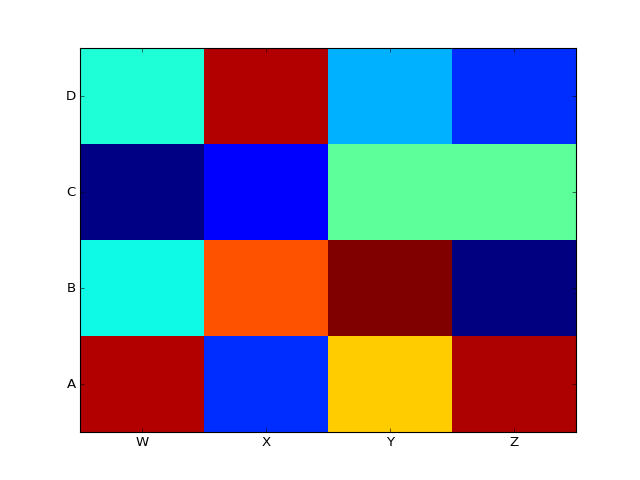

In [2]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader as web
from scipy import stats
from sklearn.neighbors.kde import KernelDensity

column_labels = list('ABCD')
row_labels = list('WXYZ')
data = np.random.rand(4,4)
fig, ax = plt.subplots()
heatmap = ax.pcolor(data)

# put the major ticks at the middle of each cell, notice "reverse" use of dimension
ax.set_yticks(np.arange(data.shape[0])+0.5, minor=False)
ax.set_xticks(np.arange(data.shape[1])+0.5, minor=False)


ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(column_labels, minor=False)
plt.show()

In [3]:
import datetime as dt
import util
import pandas as pd
import seaborn as sns; sns.set()
import pprint
sd = dt.date(2005,1,1)
ed = dt.datetime(2017,12,31)
dates = pd.date_range(sd, ed)
syms = ['GOOG','AAPL','TSLA','MSFT','AMD','HPQ','INTC','AKAM']
sym = 'AAPL'
#util.update_data(syms)
df = pd.DataFrame(web.DataReader(sym, 'google', sd, ed)['Close'])

In [4]:
symbols = pd.read_csv('data/SP500.csv',  usecols=['Symbol', 'Sector'])
sectors = set(symbols.to_dict(orient='list')['Sector'])
d = [(key,value) for (key, value) in symbols.to_dict(orient='split')['data']]
pprint.pprint(sectors)

set(['Consumer Discretionary',
     'Consumer Staples',
     'Energy',
     'Financials',
     'Health Care',
     'Industrials',
     'Information Technology',
     'Materials',
     'Real Estate',
     'Telecommunication Services',
     'Utilities'])


In [5]:
def profitmap(year,df):
    A=np.zeros( (252,252) )
    for x in range(0,252):
        for y in range(0,252):
            sd = dt.date(year,1,1)+dt.timedelta(x)
            ed = dt.date(year,1,1)+dt.timedelta(y)
            if y<x:
                ed = dt.date(year,1,1)+dt.timedelta(y+365)
            if sd in df.index and ed in df.index:
                A[x][y]=(df.loc[ed]/df.loc[sd]) -1
    return A


def profitmap2(year,df):
    sy = dt.date(year,1,1)
    data = df[sy:]
    A=np.zeros( (252,252))
    for x in range(0,252):
        for y in range(0,252):
            si = x
            ei = si + y
            A[x,y]=(data.ix[ei]/data.ix[si]) -1
    return A

def profitmap3(year,df):
    sy= dt.date(year,1,1)
    data = df[sy:]
    A=np.zeros( (252,252) )
    for x in range(0,252):
        vector = data.iloc[x:x+252]
        A[x,] = np.array((vector / vector.iloc[0]) -1).reshape(252)
    return A

def profit_density(profit_map,min_ret=0.1,max_ret=1.0):
    density_map = list()
    for row in range(0,252):
        a = profit_map[row]
        x= np.linspace(a.min(),a.max(), num=252)
        kernel = stats.gaussian_kde(a)
        density_map.append(kernel.integrate_box_1d(min_ret,max_ret))
    return density_map

In [22]:
syms = map(lambda x: x[0], filter(lambda x: x[1] == 'Financials', d))[:30]
sym_maps = []
for sym in syms:
    print sym
    df = pd.DataFrame(web.DataReader(sym, 'google', sd, ed)['Close'])
    maps = map(lambda x: profitmap3(x,df) ,range(2005,2015))
    m=np.hstack(maps)
    sym_maps.append(m)

AMG
AFL
ALL
AXP
AIG
AMP
AON
AJG
AIZ
BAC
BK
BBT
BRK.B
BLK
HRB
COF
CBOE
SCHW
CB
CINF
C
CFG
CME
CMA
DFS
ETFC
FITB
BEN
GS
HIG


(252L, 75600L)


<IPython.core.display.Javascript object>


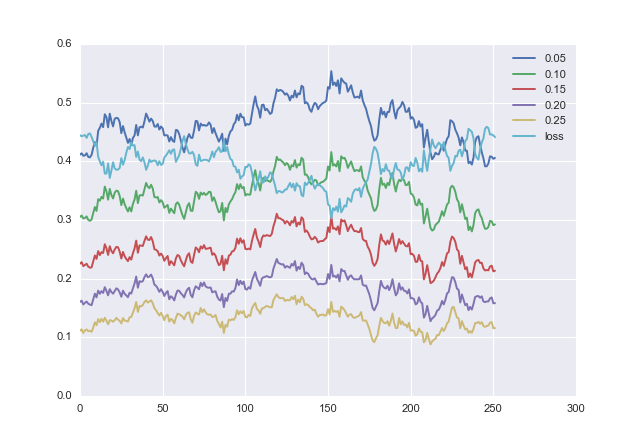

In [23]:
C=np.hstack(sym_maps)
print C.shape
fig, ax = plt.subplots()
for x in np.linspace(0.05, 0.25,5 ):
    ax.plot(profit_density(C,x,5), label="%0.2f"%x)
ax.plot(profit_density(C,-1,0), label="loss")
plt.legend()
plt.show()

In [ ]:
D=np.array(profit_density(C,0.05,5))
print D.mean()
print D.std()
s=  D.mean() +D.std()
D > s

In [24]:
year = 2016
sy = dt.date(year,1,1)          
data = df[sy:]
print data.ix[150]

Close    40.63
Name: 2016-08-08 00:00:00, dtype: float64


(252L, 504L)


<IPython.core.display.Javascript object>


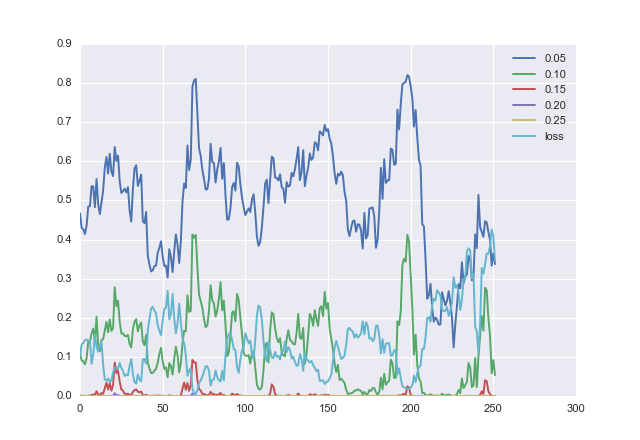

In [21]:
sym='FNCL'
df = pd.DataFrame(web.DataReader(sym, 'google', sd, ed)['Close'])
C=np.hstack( map(lambda x: profitmap3(x,df) ,range(2013,2015)))
print C.shape
fig, ax = plt.subplots()
for x in np.linspace(0.05, 0.25,5 ):
    ax.plot(profit_density(C,x,5), label="%0.2f"%x)
ax.plot(profit_density(C,-1,0), label="loss")
plt.legend()
plt.show()

In [ ]:
df['FNCL'].index[2500]

In [ ]:
goog_profitmap = lambda x: profitmap2(x,df['AKAM'])
maps = map(goog_profitmap,range(2005,2015))
A=sum(np.log(maps))
A=A/len(maps)
A= (10 ** A) -1 


In [ ]:
B=A[:,:100]
fig, ax = plt.subplots()
ax = sns.heatmap(B,xticklabels=5,yticklabels=15)

In [ ]:
def examine_year(year,sym,si,ei):
    sy = dt.date(year,1,1)   
    data = df[sym][sy:]
    a= data.ix[si]
    b= data.ix[si + ei]
    print a,b, b/a, ((b/a) -1) * 100 
    print data.index[si],data.index[si+ei]

eyear = lambda year: examine_year(year,'AKAM',121,34)
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(eyear, year=(2005,2017));

In [ ]:
a=enumerate(df['AAPL'][dt.date(2017,1,1):].index)
[x for x in a]

In [ ]:
np.argmax(A[84, ])
A[84,173]